In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import time
import math
from scipy.io import loadmat

% matplotlib inline

## Filtering the real rod currents

In [2]:
x = loadmat('rodcurrents.mat')
Data = x['rodcurrents']
Data.shape

(350, 795)

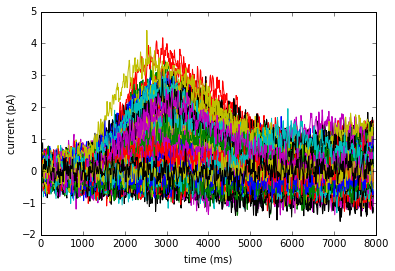

In [3]:
time = np.array(range(0,10*Data.shape[1],10))  #in ms
plt.plot(time,Data.T);
plt.xlabel('time (ms)')
plt.ylabel('current (pA)')

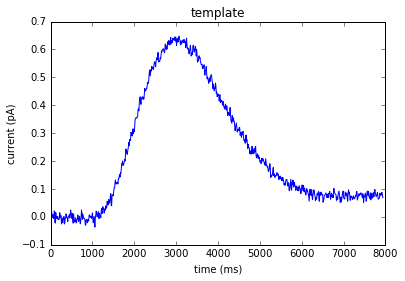

In [4]:
weight = np.mean(Data,axis=0)  #template by averaging traces
plt.plot(time,weight)
plt.title('template')
plt.xlabel('time (ms)')
plt.ylabel('current (pA)')

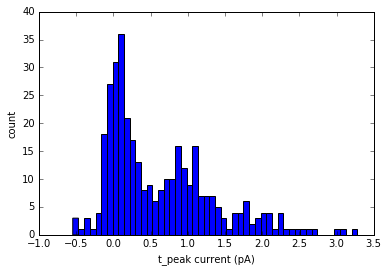

In [5]:
weight = weight/np.linalg.norm(weight)  #unit vector so convolution keeps the same unit in pA
nei = 5  #number of neighbors for temporal smoothing near the peak
count = []
for i in range(0,Data.shape[0]):
    pos = np.argmax(np.convolve(weight,Data[i,:],'same'))  #peak after convolved with template
    if pos-nei>0 and pos+nei<Data.shape[1]:
        count.append(np.mean(Data[i,pos-nei:pos+nei]))  #t_peak with neighbor avarage
    else:
        count.append(Data[i,pos])  #t_peak
aa = plt.hist(count,bins=50)
plt.xlabel('t_peak current (pA)')
plt.ylabel('count')

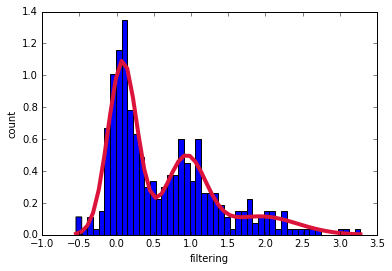

In [6]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components = 3)
gmm = gmm.fit(X=np.expand_dims(np.array(count),1))
gmm_x = aa[1]
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

fig, ax = plt.subplots()
ax.hist(count, normed=True,bins=50)
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")
plt.xlabel('filtering')
plt.ylabel('count')

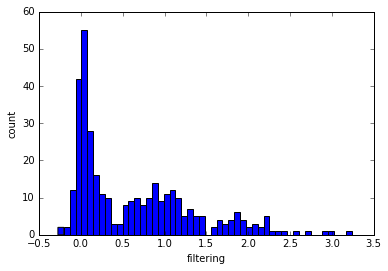

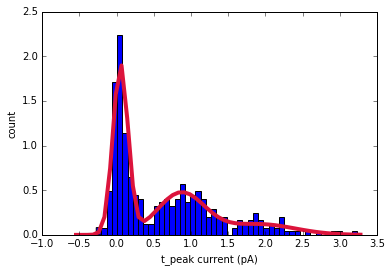

In [7]:
###potentially improving by smoothing first
box_pts = 50  #smooth window
box = np.ones(box_pts)/box_pts  #window for filtering
newData = np.array([np.convolve(Data[i,:], box, mode='same') for i in range(0,Data.shape[0])])

weight = np.mean(newData,axis=0)  #template by averaging traces
count = []
for i in range(0,Data.shape[0]):
    #count.append(np.dot(weight,newData[i,:]))  #dot product with template
    pos = np.argmax(np.convolve(weight,newData[i,:],'same'))
    if pos-nei>0 and pos+nei<Data.shape[1]:
        count.append(np.mean(newData[i,pos-nei:pos+nei]))  #t_peak with neighbor avarage
    else:
        count.append(newData[i,pos])  #t_peak
plt.hist(count,bins=50);
plt.xlabel('filtering')
plt.ylabel('count')

gmm = GaussianMixture(n_components = 3)
gmm = gmm.fit(X=np.expand_dims(np.array(count),1))
gmm_x = aa[1]
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

fig, ax = plt.subplots()
ax.hist(count, normed=True,bins=50)
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")
plt.xlabel('t_peak current (pA)')
plt.ylabel('count')

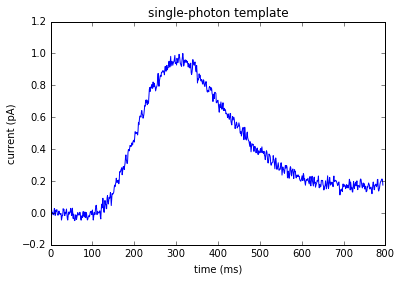

In [8]:
###Another way to improve might be carfully selecting single photon response
#but this is based on our prior knowledge that the value should be in a certain range
single_photon = np.array([r for r in Data if max(r)>1.25 and max(r)<2])
sp_weight = np.mean(single_photon,axis=0)  #template by averaging traces
plt.plot(sp_weight)
plt.title('single-photon template')
plt.xlabel('time (ms)')
plt.ylabel('current (pA)')

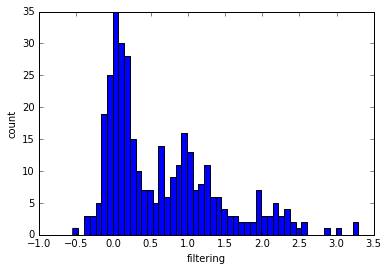

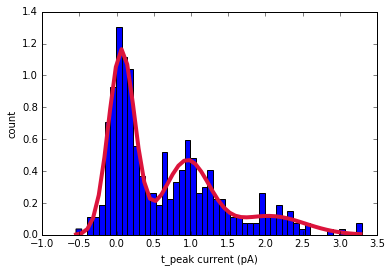

In [9]:
count = []
for i in range(0,Data.shape[0]):
    pos = np.argmax(np.convolve(sp_weight,newData[i,:],'same'))
    if pos-nei>0 and pos+nei<Data.shape[1]:
        count.append(np.mean(Data[i,pos-nei:pos+nei]))  #t_peak with neighbor avarage
    else:
        count.append(Data[i,pos])  #t_peak
plt.hist(count,bins=50);
plt.xlabel('filtering')
plt.ylabel('count')

gmm = GaussianMixture(n_components = 3)
gmm = gmm.fit(X=np.expand_dims(np.array(count),1))
gmm_x = aa[1]
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

fig, ax = plt.subplots()
ax.hist(count, normed=True,bins=50)
ax.plot(gmm_x, gmm_y, color="crimson", lw=4, label="GMM")
plt.xlabel('t_peak current (pA)')
plt.ylabel('count')

### Ans:

We can reconstruct fig 2.4 by plotting the histogram of current value at $t_{peak}$. Three ways of finding $t_{peak}$ are shown above. We convolve the responses with the average response across trials. Assuming that the trials are dominated by single-photon response, this template should be a good approximation of single-photon response kernel. We find the maximum value of the convolved traces and went back to find the current value at that time point. An extra parameter would be to select certain neighboring data point near $t_{peak}$ to average over. This method produces results that agree with fig 2.4 and can be fitted by a mixture of Gaussian, each mixture capturing different number of photon excitation.

In the next two methods, to potentially improve in performance, we can average the trials through time first to smoothen the noisy data. This prevents spurious detection of local peaks due to noise. The last method directly select trials that are known to be single-photon response based on our prior knowledge of the current amplitude. The resulting histogram is smoother but the overall conclusion is same as before. These methods should work in a dynamic region when this system is linear and assuming that we record sufficiently sparse responses with single-photon response trials.

## Overdamped Broawnian motion

Particle in a potential well separated by barrier $V_0$ and located at $+/- x_0$. Drag or friction coefficient is $\gamma$ and the Langevin force is $\zeta$:

$$
\gamma \frac { d x ( t ) } { d t } = \frac { 4 V _ { 0 } } { x _ { 0 } } \left( \frac { x } { x _ { 0 } } \right) \left[ 1 - \left( \frac { x } { x _ { 0 } } \right) ^ { 2 } \right] + \zeta ( t )
$$


where at $k_B T$: 
$$
\left\langle \zeta ( t ) \zeta \left( t ^ { \prime } \right) \right\rangle = 2 \gamma k _ { B } T \delta \left( t - t ^ { \prime } \right)
$$

In [10]:
V0 = 10  #height of barrier
x0 = 5  #+/- minimum location
dt = 0.1  #time steps
T = 30000  #total time

Integrate the Langevin equation produces the term:

$$
z ( t ) = \int _ { t } ^ { t + \Delta t } d t \zeta ( t )
$$


In [11]:
zeta_t = np.random.randn(int(T/dt))
temp = 0
zt = np.array([temp + ii for ii in zeta_t])
print(np.var(zt))

0.9981569376240184


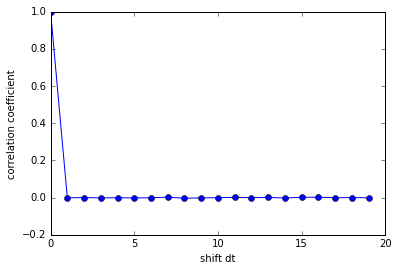

In [12]:
lag = 20
autocor = []
for l in range(0,lag):
    if l==0:
        temp = np.corrcoef(zt,zt)
    else:
        temp = np.corrcoef(zt[l:],zt[:-l])
    autocor.append(temp[0,1])
plt.plot(autocor,'-o')
plt.xlabel('shift dt')
plt.ylabel('correlation coefficient')

###->This numerically shows that the autocorrelation of z(t) is a delta-fuction

$$
\begin{aligned} \gamma \int _ { t } ^ { t + \Delta t } d t \frac { d x ( t ) } { d t } & = - \int _ { t } ^ { t + \Delta t } d t \frac { \partial V ( x ) } { \partial x } + \int _ { t } ^ { t + \Delta t } d t \zeta ( t ) \\ \gamma [ x ( t + \Delta t ) - x ( t ) ] & \approx - \Delta t \left. \frac { \partial V ( x ) } { \partial x } \right| _ { x = x ( t ) } + z ( t ) \end{aligned}
$$

Re-parameterize with $y = x / x _ { 0 }$ , parameter $\alpha = 4 k _ { B } T \Delta t / \left( \gamma x _ { 0 } ^ { 2 } \right)$, and energy $E ^ { \dagger } = V _ { 0 } / \left( k _ { B } T \right)$:

$$
y ( n + 1 ) = y ( n ) + \alpha E ^ { \dagger } \cdot y ( n ) \cdot \left[ 1 - y ^ { 2 } ( n ) \right] + \sqrt { \frac { \alpha } { 2 } } \xi ( n )
$$

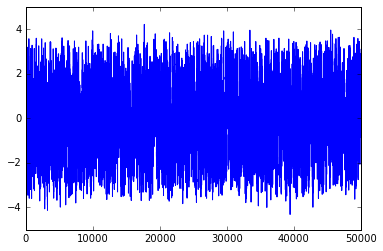

In [13]:
#test
gamma = 10
kBT = 300
alpha = 4*kBT*dt/(gamma*x0**2)
E_ = V0/kBT
y = np.zeros(int(T/dt))
for nn in range(0,len(y)-1):
    y[nn+1] = y[nn] + alpha*E_*y[nn]*(1-y[nn]**2) + np.sqrt(alpha/2)*zeta_t[nn]
plt.plot(y[:50000])  #plot part of the trace

In [14]:
def y_SDE(alpha,E_,dt,T):
    '''
    Simulating SDE shown in the re-parameterized Langevin equation
    '''
    y = np.zeros(int(T/dt))
    for nn in range(0,len(y)-1):
        y[nn+1] = y[nn] + alpha*E_*y[nn]*(1-y[nn]**2) + np.sqrt(alpha/2)*zeta_t[nn]
    return y

For each value of $E^†$, check that your simulation runs long enough so that the distribution of $x$ actually is given by the Boltzmann distribution $P(x)\propto exp[−V(x)/k_BT]$. As $E^†$ increases,can you see that there are isolated discrete events corresponding to the chemical reaction in which the system jumps from one well to the other? Use your simulation to estimate the rate of these jumps, and plot the rate as a function of the activation energy $E^†$. Can you verify the Arrhenius law?

In [15]:
###Explore alpha values
Etemp = 0.01
alphas = np.linspace(0.1,5,10)
for aa in alphas:
    print('alpha=',aa,'variance of y=',np.var(y_SDE(aa,Etemp,dt,T)))
###->alpha should not be larger than 4.5-5 to produce stable finite time series

alpha= 0.1 variance of y= 3.550568794762034
alpha= 0.6444444444444445 variance of y= 3.624769343420051
alpha= 1.188888888888889 variance of y= 3.648991660911987
alpha= 1.7333333333333336 variance of y= 3.664234034789425
alpha= 2.277777777777778 variance of y= 3.678035341981298
alpha= 2.8222222222222224 variance of y= 3.701896959322372
alpha= 3.366666666666667 variance of y= 3.7514297334753226


/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in double_scalars
/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


alpha= 3.911111111111112 variance of y= nan
alpha= 4.455555555555556 variance of y= nan
alpha= 5.0 variance of y= nan


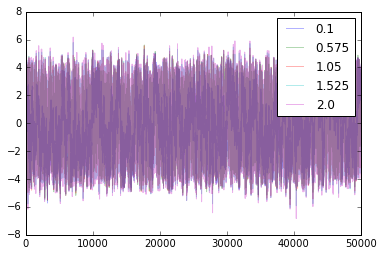

In [16]:
#visulization
Etemp = 0.01
alphas = np.linspace(0.1,2,5)
for aa in alphas:
    plt.plot(y_SDE(aa,Etemp,dt,T)[:50000],label=aa,alpha=0.3)
    plt.hold(True)
plt.legend()

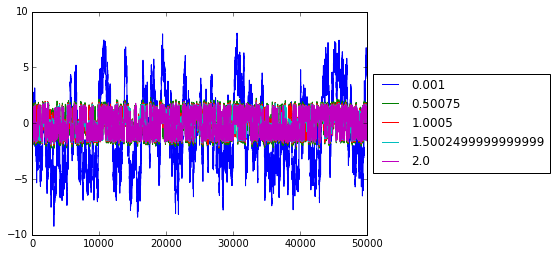

In [17]:
###Explore energy E'
Es = np.linspace(0.001,2,5)
alpha = 0.1
for EE in Es:
    plt.plot(y_SDE(alpha,EE,dt,T)[:50000],label=EE)
    plt.hold(True)
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

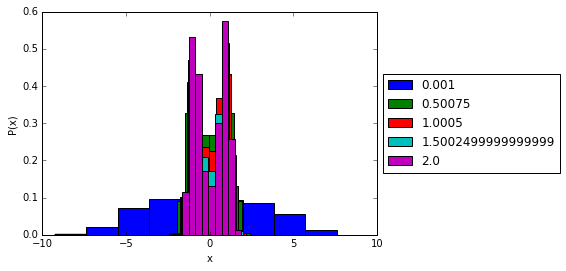

In [18]:
###Explore energy E'
Es = np.linspace(0.001,2,5)
alpha = 0.1
for EE in Es:
    plt.hist(y_SDE(alpha,EE,dt,T),label=str(EE),normed=True);
    plt.hold(True)
plt.legend()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('x')
plt.ylabel('P(x)')

In [19]:
#check Boltzman~
pp,xx = np.histogram(y_SDE(alpha,EE,dt,T)*x0,normed=True,bins=50);  #turning y back to x by multiplying x0

/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  from ipykernel import kernelapp as app


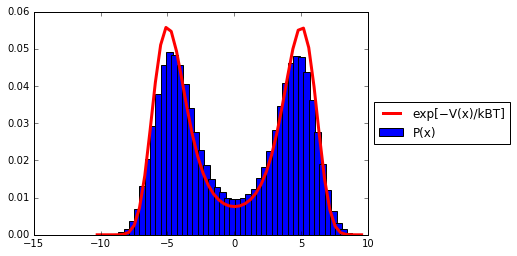

In [20]:
Pb = np.exp(-EE*(1-(xx/x0)**2)**2)#np.exp(-V0*(1-(xx/x0)**2)**2/kBT)
Pb = Pb/np.sum(Pb)
plt.plot(xx,Pb,'r',linewidth=3,label='exp[−V(x)/kBT]')
plt.hold(True)
#plt.hist(y_SDE(alpha,EE,dt,T)*x0,label=str(EE),normed=True);
plt.bar(xx[:-1],pp/sum(pp),width=.5,label='P(x)')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [21]:
def transiton_rate(x,threshold,dt):
    '''
    Input time series of x and the threshold that it should be crossing through time.
    The event of threshold/barrier crossing is detected and the rate of transition is estimated from dt steps
    '''
    sub = x - threshold
    temp = np.multiply(sub[1:],sub[:-1])
    cross = np.where(temp<0)[0]
    rate = 1/(np.diff(cross)*dt)
    return rate

In [22]:
est_r = []
threshold = 0
Es = np.linspace(0.001,8,30)
alpha = 0.1
for EE in Es:
    est_r.append(np.mean(transiton_rate(y_SDE(alpha,EE,dt,T),threshold,dt)))
    #est_r.append(transiton_rate(y_SDE(alpha,EE,dt,T),threshold,dt))

/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in double_scalars
/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars
/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less
/Users/Macintosh/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: overflow encountered in multiply


In [23]:
#fitting with Arrhenius law
expfit = np.polyfit(Es, np.log(est_r), 1)
print(expfit)

[-0.0635717   1.45894636]


In [24]:
print('kBT=',-1/expfit[0])

kBT= 15.730269152693795


In [25]:
print('True kBT=',0.1/4/dt*gamma*x0)  #reconstruct from the alpha value we use~
###not bad~

True kBT= 12.5


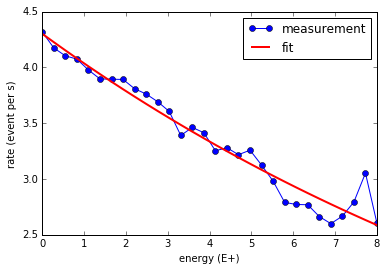

In [26]:
plt.plot(Es,est_r,'-o',label='measurement')
plt.xlabel('energy (E+)')
plt.ylabel('rate (event per s)')
plt.hold(True)
plt.plot(Es,np.exp(expfit[1])*np.exp(Es*expfit[0]),'r-',linewidth=2,label='fit')
plt.legend()

### Ans:

We can formulate the Langevin equation in terms of $y$ and discrete iterations following eqn 4.8. By scanning through the variance of time traces, $\alpha$ value should be sufficiently small for the system to be stable as the time step $\delta t$ is included in the variable $\alpha$. When $E^†$ is large enough, the trajectories cross between two potential wells and forms more discrete behavior. The distribution $P(x)$ agrees with the Boltzmann distribution in the long time series simulatin. In the end, the transition rate between two states is changed by $E^†$ in the form $rate\propto e^{E^†/k_BT}$, where we do an exponential fit and could approximately get $k_BT$ back.